#**Step 1: Prepare the Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Mounted at /content/drive


In [3]:
#import dataset
videogame_data = "/content/drive/Shareddrives/Project 4 (Neural Networks)/video_game_reviews.csv"

In [4]:
df = pd.read_csv(videogame_data)
df.head()

,Game Title,User Rating,Age Group Targeted,Price,Platform,Requires Special Device,Developer,Publisher,Release Year,Genre,Multiplayer,Game Length (Hours),Graphics Quality,Soundtrack Quality,Story Quality,User Review Text,Game Mode,Min Number of Players
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015,Adventure,No,55.3,Medium,Average,Poor,"Solid game, but too many bugs.",Offline,1
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015,Shooter,Yes,34.6,Low,Poor,Poor,"Solid game, but too many bugs.",Offline,3
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012,Adventure,Yes,13.9,Low,Good,Average,"Great game, but the graphics could be better.",Offline,5
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015,Sports,No,41.9,Medium,Good,Excellent,"Solid game, but the graphics could be better.",Online,4
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022,RPG,Yes,13.2,High,Poor,Good,"Great game, but too many bugs.",Offline,1


In [34]:
# Rename columns
new_columns = {}
for col in df.columns:
    new_col = col.lower().replace(" ", "_")
    new_columns[col] = new_col
df = df.rename(columns=new_columns)

df.head()

,game_title,user_rating,age_group_targeted,price,platform,requires_special_device,developer,publisher,release_year,genre,multiplayer,game_length_(hours),graphics_quality,soundtrack_quality,story_quality,user_review_text,game_mode,min_number_of_players
0,Grand Theft Auto V,36.4,1,0.126615,2,0,5,4,2015,1,0,1.437616,2,Average,3,"Solid game, but too many bugs.",0,-1.486467
1,The Sims 4,38.3,0,1.528497,2,0,7,2,2015,6,1,0.133460,1,Poor,3,"Solid game, but too many bugs.",0,-0.764313
2,Minecraft,26.8,3,0.432164,2,1,0,1,2012,1,1,-1.170695,1,Good,0,"Great game, but the graphics could be better.",0,-0.042159
3,Bioshock Infinite,38.4,1,0.723825,0,1,5,5,2015,8,0,0.593380,2,Good,1,"Solid game, but the graphics could be better.",1,-0.403236
4,Half-Life: Alyx,30.1,0,1.348813,3,1,5,3,2022,5,1,-1.214797,0,Poor,2,"Great game, but too many bugs.",0,-1.486467


In [6]:
print(len(df['graphics_quality'].unique()))

4


In [10]:
target_col     = "user_rating"
num_cols       = ["price", "game_length_(hours)", "min_number_of_players"]          # numerical
small_cat_cols = ["platform", "game_mode", "requires_special_device", "graphics_quality", "multiplayer", "story_quality", "age_group_targeted"]                          # ≤ ~10 categories
big_cat_cols   = ["publisher", "genre", "developer"]                             # dozens / hundreds
cat_cols       = small_cat_cols + big_cat_cols

In [11]:
encoders = {}
for col in cat_cols:
    le = LabelEncoder().fit(df[col].astype(str))
    df[col] = le.transform(df[col].astype(str))
    encoders[col] = le          # save for inference

In [12]:
scaler = StandardScaler().fit(df[num_cols])
df[num_cols] = scaler.transform(df[num_cols])

In [15]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# **Step 2: Create the Dataset**

In [17]:
from torch.utils.data import Dataset

class TabularDataset(Dataset):
    def __init__(self, dataframe, cat_cols, num_cols, y_col):
        self.cats = dataframe[cat_cols].values.astype("int64")
        self.nums = dataframe[num_cols].values.astype("float32")
        self.y    = dataframe[y_col].values.astype("float32").reshape(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.cats[idx], self.nums[idx], self.y[idx]

# **Step 3: Build the model**

In [18]:
# Calculate n_categories before using it.
n_categories = sum(df[col].nunique() for col in cat_cols)

# Now you can calculate embed_dim:
embed_dim = min(50, n_categories // 2)  # fast.ai guideline

In [19]:
#embed_dim = min(50, n_categories // 2)  # fast.ai guideline

In [20]:
import torch.nn as nn
import math

def make_embedding_sizes(df, cat_cols):
    sizes = []
    for col in cat_cols:
        n_cat = df[col].nunique()
        dim   = min(50, (n_cat + 1) // 2)  # +1 for OOV padding if you like
        sizes.append((n_cat, dim))
    return sizes

embedding_sizes = make_embedding_sizes(df, cat_cols)

# **3.2 Model definition**

In [22]:
# class TabularRegressor(nn.Module):
#     def __init__(self, embedding_sizes, n_numeric, hidden_dims=[128, 64], p_dropout=0.1):
#         super().__init__()

#         # 1️⃣ Embeddings for each categorical column
#         self.embeddings = nn.ModuleList(
#             [nn.Embedding(n_cat, dim) for n_cat, dim in embedding_sizes]
#         )
#         emb_out_dim = sum(dim for _, dim in embedding_sizes)

#         # 2️⃣ Linear stack
#         layer_sizes = [emb_out_dim + n_numeric] + hidden_dims + [1]
#         layers = []
#         for i in range(len(layer_sizes) - 2):
#             layers += [
#                 nn.Linear(layer_sizes[i], layer_sizes[i+1]),
#                 nn.BatchNorm1d(layer_sizes[i+1]),
#                 nn.ReLU(),
#                 nn.Dropout(p_dropout),
#             ]
#         layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))  # output
#         self.mlp = nn.Sequential(*layers)

#     def forward(self, x_cat, x_num):
#         embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
#         x    = torch.cat(embs + [x_num], dim=1)
#         return self.mlp(x)

In [24]:
class TabularRegressor(nn.Module):
    def __init__(self, embedding_sizes, n_numeric, hidden_dims=[128, 64], p_dropout=0.1):
        super().__init__()

        # 1️⃣ Create embeddings for each categorical column
        self.embeddings = nn.ModuleList(
            [nn.Embedding(n_cat, dim) for n_cat, dim in embedding_sizes]
        )
        emb_out_dim = sum(dim for _, dim in embedding_sizes)

        # 2️⃣ Define layers
        self.fc1 = nn.Linear(emb_out_dim + n_numeric, hidden_dims[0])  # First linear layer
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])  # BatchNorm layer for fc1
        self.relu1 = nn.ReLU()  # ReLU activation
        self.dropout1 = nn.Dropout(p_dropout)  # Dropout after fc1

        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])  # Second linear layer
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])  # BatchNorm layer for fc2
        self.relu2 = nn.ReLU()  # ReLU activation
        self.dropout2 = nn.Dropout(p_dropout)  # Dropout after fc2

        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[1])  # Second linear layer
        self.bn3 = nn.BatchNorm1d(hidden_dims[1])  # BatchNorm layer for fc2
        self.relu3 = nn.ReLU()  # ReLU activation
        self.dropout3 = nn.Dropout(p_dropout)  # Dropout after fc2

        self.fc4 = nn.Linear(hidden_dims[1], 1)  # Output layer (regression)

    def forward(self, x_cat, x_num):
        # Embedding lookup for categorical data
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(embs + [x_num], dim=1)  # Concatenate embeddings and numerical data

        # Pass through the layers one by one
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)  # Final output

        return x

# **4. PyTorch has nn.MSELoss() but no built-in RMSE**

Taking sqrt of the MSE works, but a small ε avoids NaN gradients

In [25]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y) + self.eps)

# **5. Train**

In [26]:
# device   = "cuda" if torch.cuda.is_available() else "cpu"
# model    = TabularRegressor(embedding_sizes, len(num_cols)).to(device)
# criterion = RMSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# train_dl = DataLoader(TabularDataset(train_df, cat_cols, num_cols, target_col),
#                       batch_size=1024, shuffle=True)
# val_dl   = DataLoader(TabularDataset(val_df,   cat_cols, num_cols, target_col),
#                       batch_size=2048)

# for epoch in range(30):
#     model.train()
#     for cats, nums, y in train_dl:
#         cats, nums, y = cats.to(device), nums.to(device), y.to(device)
#         preds = model(cats, nums)
#         loss  = criterion(preds, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # quick validation
#     model.eval()
#     with torch.no_grad():
#         val_losses = []
#         for cats, nums, y in val_dl:
#             cats, nums, y = cats.to(device), nums.to(device), y.to(device)
#             val_losses.append(criterion(model(cats, nums), y).item())
#     print(f"epoch {epoch:02d}  train_rmse={loss.item():.4f}  val_rmse={sum(val_losses)/len(val_losses):.4f}")

In [27]:
import torch
from torch.utils.data import DataLoader
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# ── 1.  Model, loss, optimiser ──────────────────────────────────────────────────
model = TabularRegressor(embedding_sizes, len(num_cols)).to(device)

criterion = torch.nn.MSELoss()                  # train with MSE …
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ── 2.  DataLoaders ─────────────────────────────────────────────────────────────
train_dl = DataLoader(
    TabularDataset(train_df, cat_cols, num_cols, target_col),
    batch_size=1024, shuffle=True)

val_dl = DataLoader(
    TabularDataset(val_df, cat_cols, num_cols, target_col),
    batch_size=2048)

# ── 3.  Training loop ───────────────────────────────────────────────────────────
for epoch in range(30):
    # ---- training phase ----
    model.train()
    for cats, nums, y in train_dl:
        cats, nums, y = cats.to(device), nums.to(device), y.to(device)

        preds = model(cats, nums)
        loss  = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ---- full-train RMSE (no dropout, no BN stats update) ----
    model.eval()
    with torch.no_grad():
        tr_losses, val_losses = [], []

        # full train set
        for cats, nums, y in train_dl:
            cats, nums, y = cats.to(device), nums.to(device), y.to(device)
            tr_losses.append(criterion(model(cats, nums), y).item())

        # validation set
        for cats, nums, y in val_dl:
            cats, nums, y = cats.to(device), nums.to(device), y.to(device)
            val_losses.append(criterion(model(cats, nums), y).item())

    train_rmse = np.sqrt(np.mean(tr_losses))
    val_rmse   = np.sqrt(np.mean(val_losses))
    print(f"epoch {epoch:02d} | train_RMSE={train_rmse:.3f} | val_RMSE={val_rmse:.3f}")

epoch 00 | train_RMSE=29.520 | val_RMSE=29.449
epoch 01 | train_RMSE=28.129 | val_RMSE=28.075
epoch 02 | train_RMSE=26.652 | val_RMSE=26.596
epoch 03 | train_RMSE=23.841 | val_RMSE=23.811
epoch 04 | train_RMSE=21.497 | val_RMSE=21.477
epoch 05 | train_RMSE=18.713 | val_RMSE=18.710
epoch 06 | train_RMSE=16.041 | val_RMSE=16.028
epoch 07 | train_RMSE=13.646 | val_RMSE=13.638
epoch 08 | train_RMSE=11.389 | val_RMSE=11.396
epoch 09 | train_RMSE=9.539 | val_RMSE=9.537
epoch 10 | train_RMSE=7.444 | val_RMSE=7.448
epoch 11 | train_RMSE=5.222 | val_RMSE=5.229
epoch 12 | train_RMSE=4.194 | val_RMSE=4.201
epoch 13 | train_RMSE=3.321 | val_RMSE=3.339
epoch 14 | train_RMSE=2.657 | val_RMSE=2.671
epoch 15 | train_RMSE=2.140 | val_RMSE=2.155
epoch 16 | train_RMSE=1.685 | val_RMSE=1.698
epoch 17 | train_RMSE=1.653 | val_RMSE=1.666
epoch 18 | train_RMSE=1.488 | val_RMSE=1.504
epoch 19 | train_RMSE=1.346 | val_RMSE=1.362
epoch 20 | train_RMSE=1.292 | val_RMSE=1.305
epoch 21 | train_RMSE=1.300 | val_RMS

# **Inference helper**

In [28]:
def predict(df_batch: pd.DataFrame):
    ds = TabularDataset(df_batch, cat_cols, num_cols, target_col)
    dl = DataLoader(ds, batch_size=2048)
    model.eval()
    out = []
    with torch.no_grad():
        for cats, nums, _ in dl:
            cats, nums = cats.to(device), nums.to(device)
            out.append(model(cats, nums).cpu())
    return torch.cat(out).squeeze(1).numpy()

In [29]:
# Based on that we can now predict ratings, to see how close the predicted rating is to the real rating.

model.eval()

# Take 5 random validation samples
sample = df.sample(5)

cats = torch.tensor(sample[cat_cols].values).long().to(device)
nums = torch.tensor(sample[num_cols].values).float().to(device)

# Predict
preds = model(cats, nums)
print("Predicted ratings:", preds.view(-1).cpu().detach().numpy())
print("Actual ratings:", sample[target_col].values)

Predicted ratings: [24.966982 35.473545 21.07809  18.938293 41.890873]
Actual ratings: [27.4 37.3 22.8 19.5 43.8]


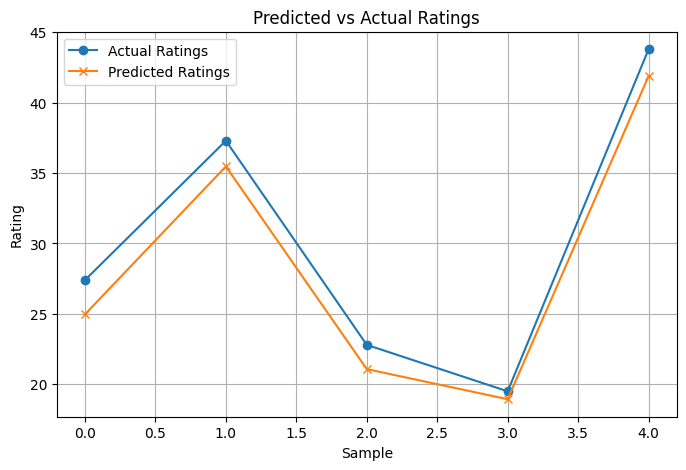

In [32]:
# Graphing results

import matplotlib.pyplot as plt

predicted = preds.view(-1).cpu().detach().numpy()
actual = sample[target_col].values

plt.figure(figsize=(8, 5))
plt.plot(range(len(actual)), actual, marker='o', label='Actual Ratings')
plt.plot(range(len(predicted)), predicted, marker='x', label='Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.xlabel('Sample')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
import numpy as np
# calculate the baseline using the mean of the target variable
baseline_rmse = np.sqrt(np.mean((df[target_col] - df[target_col].mean())**2))
print(f"Baseline RMSE (using mean): {baseline_rmse:.4f}")

Baseline RMSE (using mean): 7.5501
